# Predicting Fatalities from Tornado Data (Group 1)

**Authors**: Erika Delorme, Marcela Flaherty, Riddha Tuladhar, Edwin Yeung

# Summary

# Introduction

Tornadoes are a common type of natural disaster in the United States; in fact, the United States gets more tornadoes than any other country at over 1,150 thousand recorded every year (Chinchar, A. 2022). Furthermore, the United States has experienced many of the most violent tornadoes, with 59 of the 67 most violent tornadoes in recorded history taking place in the country (Storm Prediction Center, 2023). As such, the ability to predict the number of fatalities caused by these tornadoes based on their physical characteristics is desirable in order to employ preventative measures and reduce the number of casualties caused by these disasters.

This project will be using a data set from the US NOAA’s Storm Prediction Cente (Storm Prediction Center, 2023), which contains information on all tornadoes recorded in the United States from 1950 to 2022. For each tornado, the data set records many of its features, including but not limited to its length, width, the state in the US, the date and time it occurred, the number of fatalities and the number of injuries it caused, and the financial losses it incurred. Using this information, this project will use a multivariable linear regression to answer the question “How does the length and width of a tornado affect the number of fatalities it causes?”

# Methods

## Data wrangling and cleaning

The R programming language (R Core Team, 2022)  and the following R packages were used to conduct our analysis: repr (Angerer et al., 2023), tidyverse (Hadley Wickham & RStudio, 2017), tidymodels (Kuhn et al., 2023), psych (Revelle, 2019), and GGally (Schloerke et al., 2020).

The code used to perform the analysis and create this report can be found here: https://github.com/DSCI-310-2024/DSCI-310-Group-1-Predict-Fatalities-From-Tornado-Data/blob/main/src/tornado_fatalities_predictor.ipynb. 

1. First, we load the necessary packages. 

In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
library(psych)
library(GGally)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────────────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5      ✔ rsample      1.2.0 
✔ dials        1.2.1      ✔ tune         1.1.2 
✔ infer        1.0.6      ✔ workflows    1.1.4 
✔ modeldata    1.3.0      ✔ workflowsets 1.0.1 
✔ parsnip      1.2.0      ✔ yardstick    1.3.0 
✔ recipes      1.0.10     

── Con

2. Then, we read in the data about tornadoes directly from the website. 

In [2]:
# Load data
URL <- "https://raw.githubusercontent.com/rfordatascience/tidytuesday/a9e277dd77331e9091e151bb5adb584742064b3e/data/2023/2023-05-16/tornados.csv"
tornado_data <- read.csv(URL)

head(tornado_data)

,om,yr,mo,dy,date,time,tz,datetime_utc,st,stf,⋯,elon,len,wid,ns,sn,f1,f2,f3,f4,fc
,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,⋯,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<lgl>
1,192,1950,10,1,1950-10-01,21:00:00,America/Chicago,1950-10-02T03:00:00Z,OK,40,⋯,-102.30,15.8,10,1,1,25,0,0,0,FALSE
2,193,1950,10,9,1950-10-09,02:15:00,America/Chicago,1950-10-09T08:15:00Z,NC,37,⋯,0.00,2.0,880,1,1,47,0,0,0,FALSE
3,195,1950,11,20,1950-11-20,02:20:00,America/Chicago,1950-11-20T08:20:00Z,KY,21,⋯,0.00,0.1,10,1,1,177,0,0,0,FALSE
4,196,1950,11,20,1950-11-20,04:00:00,America/Chicago,1950-11-20T10:00:00Z,KY,21,⋯,0.00,0.1,10,1,1,209,0,0,0,FALSE
5,197,1950,11,20,1950-11-20,07:30:00,America/Chicago,1950-11-20T13:30:00Z,MS,28,⋯,0.00,2.0,37,1,1,101,0,0,0,FALSE
6,194,1950,11,4,1950-11-04,17:00:00,America/Chicago,1950-11-04T23:00:00Z,PA,42,⋯,-75.93,15.9,100,1,1,71,11,0,0,FALSE


3. Next, we wrangle and clean the data. Firstly, we check for missing values in our cleaned data.

In [3]:
sapply(tornado_data, function(x) sum(is.na(x)))

om           yr           mo           dy         date         time 
           0            0            0            0            0            0 
          tz datetime_utc           st          stf          mag          inj 
           0            0            0            0          756            0 
         fat         loss         slat         slon         elat         elon 
           0        27170            0            0            0            0 
         len          wid           ns           sn           f1           f2 
           0            0            0            0            0            0 
          f3           f4           fc 
           0            0            0

We can see that there are no missing values, except for the feature `loss`, with 27,170 missing values and 756 missing values for the feature mag.  The feature `loss` refers to the financial loss of each tornado. For our regression problem, we did not deem this feature to be an important feature. Therefore, we decide to remove this column. 

Because there are not so many rows missing for the feature `mag`, we decide to filter those rows out. 

4. Then, we remove irrelevant or repetitive columns and then filter for missing values of the column `mag`, which stands for magnitude. Then, we change the feature names to make them more descriptive. We show the top 6 rows of our cleaned data. 

In [4]:
# Wrangle and clean data

# Remove irrelevant or repetitive columns, and filter for NA in magnitude
df <- tornado_data %>%
    select(-date, -tz, -stf, -sn, -f1, -f2, -f3, -f4, -fc, -loss) %>%
    filter(!is.na(mag)) 

# Change feature names to be more descriptive
names(df) <- c('ID','year','month','day','time','datetime_utc','state','mag','injuries',
               'fatalities','start_lat','start_lon','end_lat','end_lon','length','width','ns')

head(df)

,ID,year,month,day,time,datetime_utc,state,mag,injuries,fatalities,start_lat,start_lon,end_lat,end_lon,length,width,ns
,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,192,1950,10,1,21:00:00,1950-10-02T03:00:00Z,OK,1,0,0,36.73,-102.52,36.88,-102.30,15.8,10,1
2,193,1950,10,9,02:15:00,1950-10-09T08:15:00Z,NC,3,3,0,34.17,-78.60,0.00,0.00,2.0,880,1
3,195,1950,11,20,02:20:00,1950-11-20T08:20:00Z,KY,2,0,0,37.37,-87.20,0.00,0.00,0.1,10,1
4,196,1950,11,20,04:00:00,1950-11-20T10:00:00Z,KY,1,0,0,38.20,-84.50,0.00,0.00,0.1,10,1
5,197,1950,11,20,07:30:00,1950-11-20T13:30:00Z,MS,1,3,0,32.42,-89.13,0.00,0.00,2.0,37,1
6,194,1950,11,4,17:00:00,1950-11-04T23:00:00Z,PA,3,1,0,40.20,-76.12,40.40,-75.93,15.9,100,1


In [3]:
# This is to export cleaned data frame to new csv file
#write_csv(df, "C:\\Users\\Erika\\DSCI-310-Group-1-Predict-Fatalities-From-Tornado-Data\\data\\processed\\cleaned_tornado_data.csv")

## EDA: Descriptive statistics and visualizations

5. Next, we create a summary table of features that could be useful to use in our regression model. 

In [5]:
describe(df[, c('mag', 'injuries', 'fatalities', 'start_lat', 'start_lon', 'end_lat', 'end_lon', 
                'length', 'width', 'ns')], fast = TRUE)

,vars,n,mean,sd,min,max,range,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mag,1,67937,0.77872146,0.89578979,0.0000,5.0000,5.0000,0.0034367894
injuries,2,67937,1.43447606,18.21464265,0.0000,1740.0000,1740.0000,0.0698823454
fatalities,3,67937,0.09030425,1.48025841,0.0000,158.0000,158.0000,0.0056791633
start_lat,4,67937,37.12084145,5.10796577,17.7212,61.0200,43.2988,0.0195972348
start_lon,5,67937,-92.70567031,8.67919628,-163.5300,-64.7151,98.8149,0.0332986271
end_lat,6,67937,22.79438471,18.55826645,0.0000,61.0200,61.0200,0.0712006934
end_lon,7,67937,-56.38062159,45.38037316,-163.5300,0.0000,163.5300,0.1741064579
length,8,67937,3.51464195,8.28672352,0.0000,234.7000,234.7000,0.0317928651
width,9,67937,108.42309787,207.81143767,0.0000,4576.0000,4576.0000,0.7972899033


**Table 1**: Summary table of numerical features

6. We create a correlation matrix to view the correlations between features related to `injuries` and `fatalities`. 

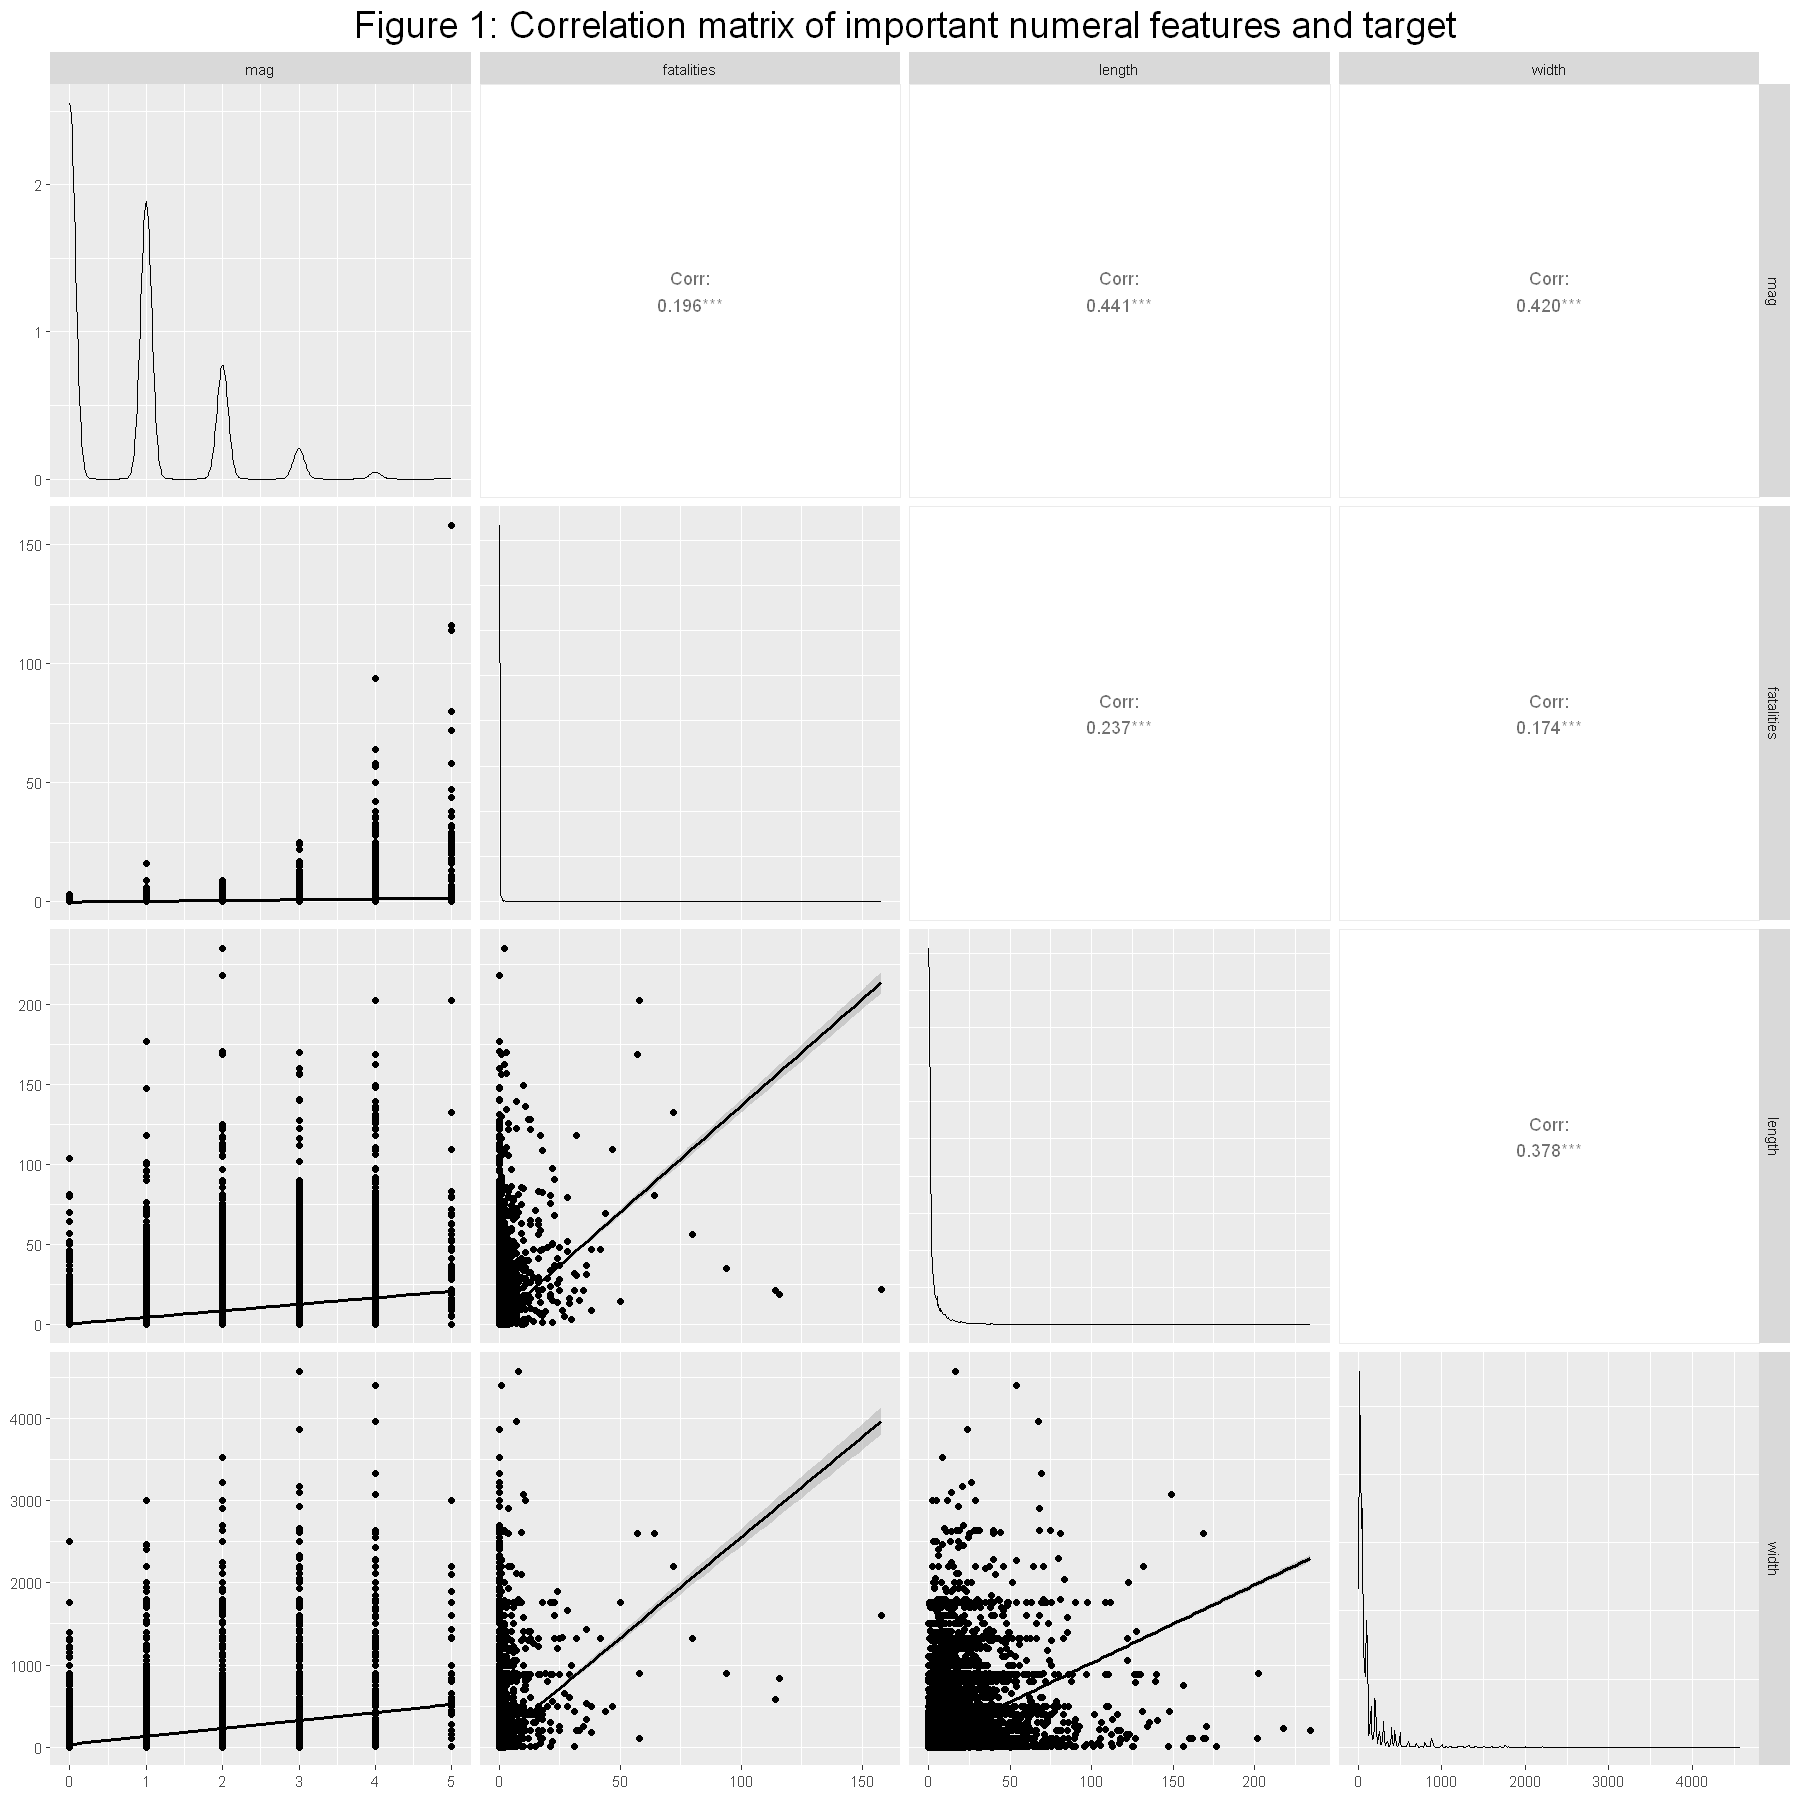

In [6]:
options(repr.plot.width = 15, repr.plot.height = 15)

correlations_plot <- df %>%
    ggpairs(
        columns = c("mag", "fatalities", "length", "width"), 
        lower = list(
            continuous = "smooth", 
            combo = wrap("facethist", binwidth = 2)), 
        title = "Figure 1: Correlation matrix of important numeral features and target") +
    theme(plot.title = element_text(size = 22, hjust = 0.5)) 
correlations_plot

From the correlation matrix, we observe that there are some small sized correlations between `fatalities` and other continuous features. For example, there is a correlation of `0.237` between `length` and `fatalities` and a correlation of `0.174` between `width` and `fatalities`.

There are also correlations between features that are not the target. For example, there is medium sized correlation of `0.441` between `length` and `mag` and a correlation of 0.420 between `width` and `mag`.

These small to medium correlations may suggest that these features could be useful in predicting fatalities.

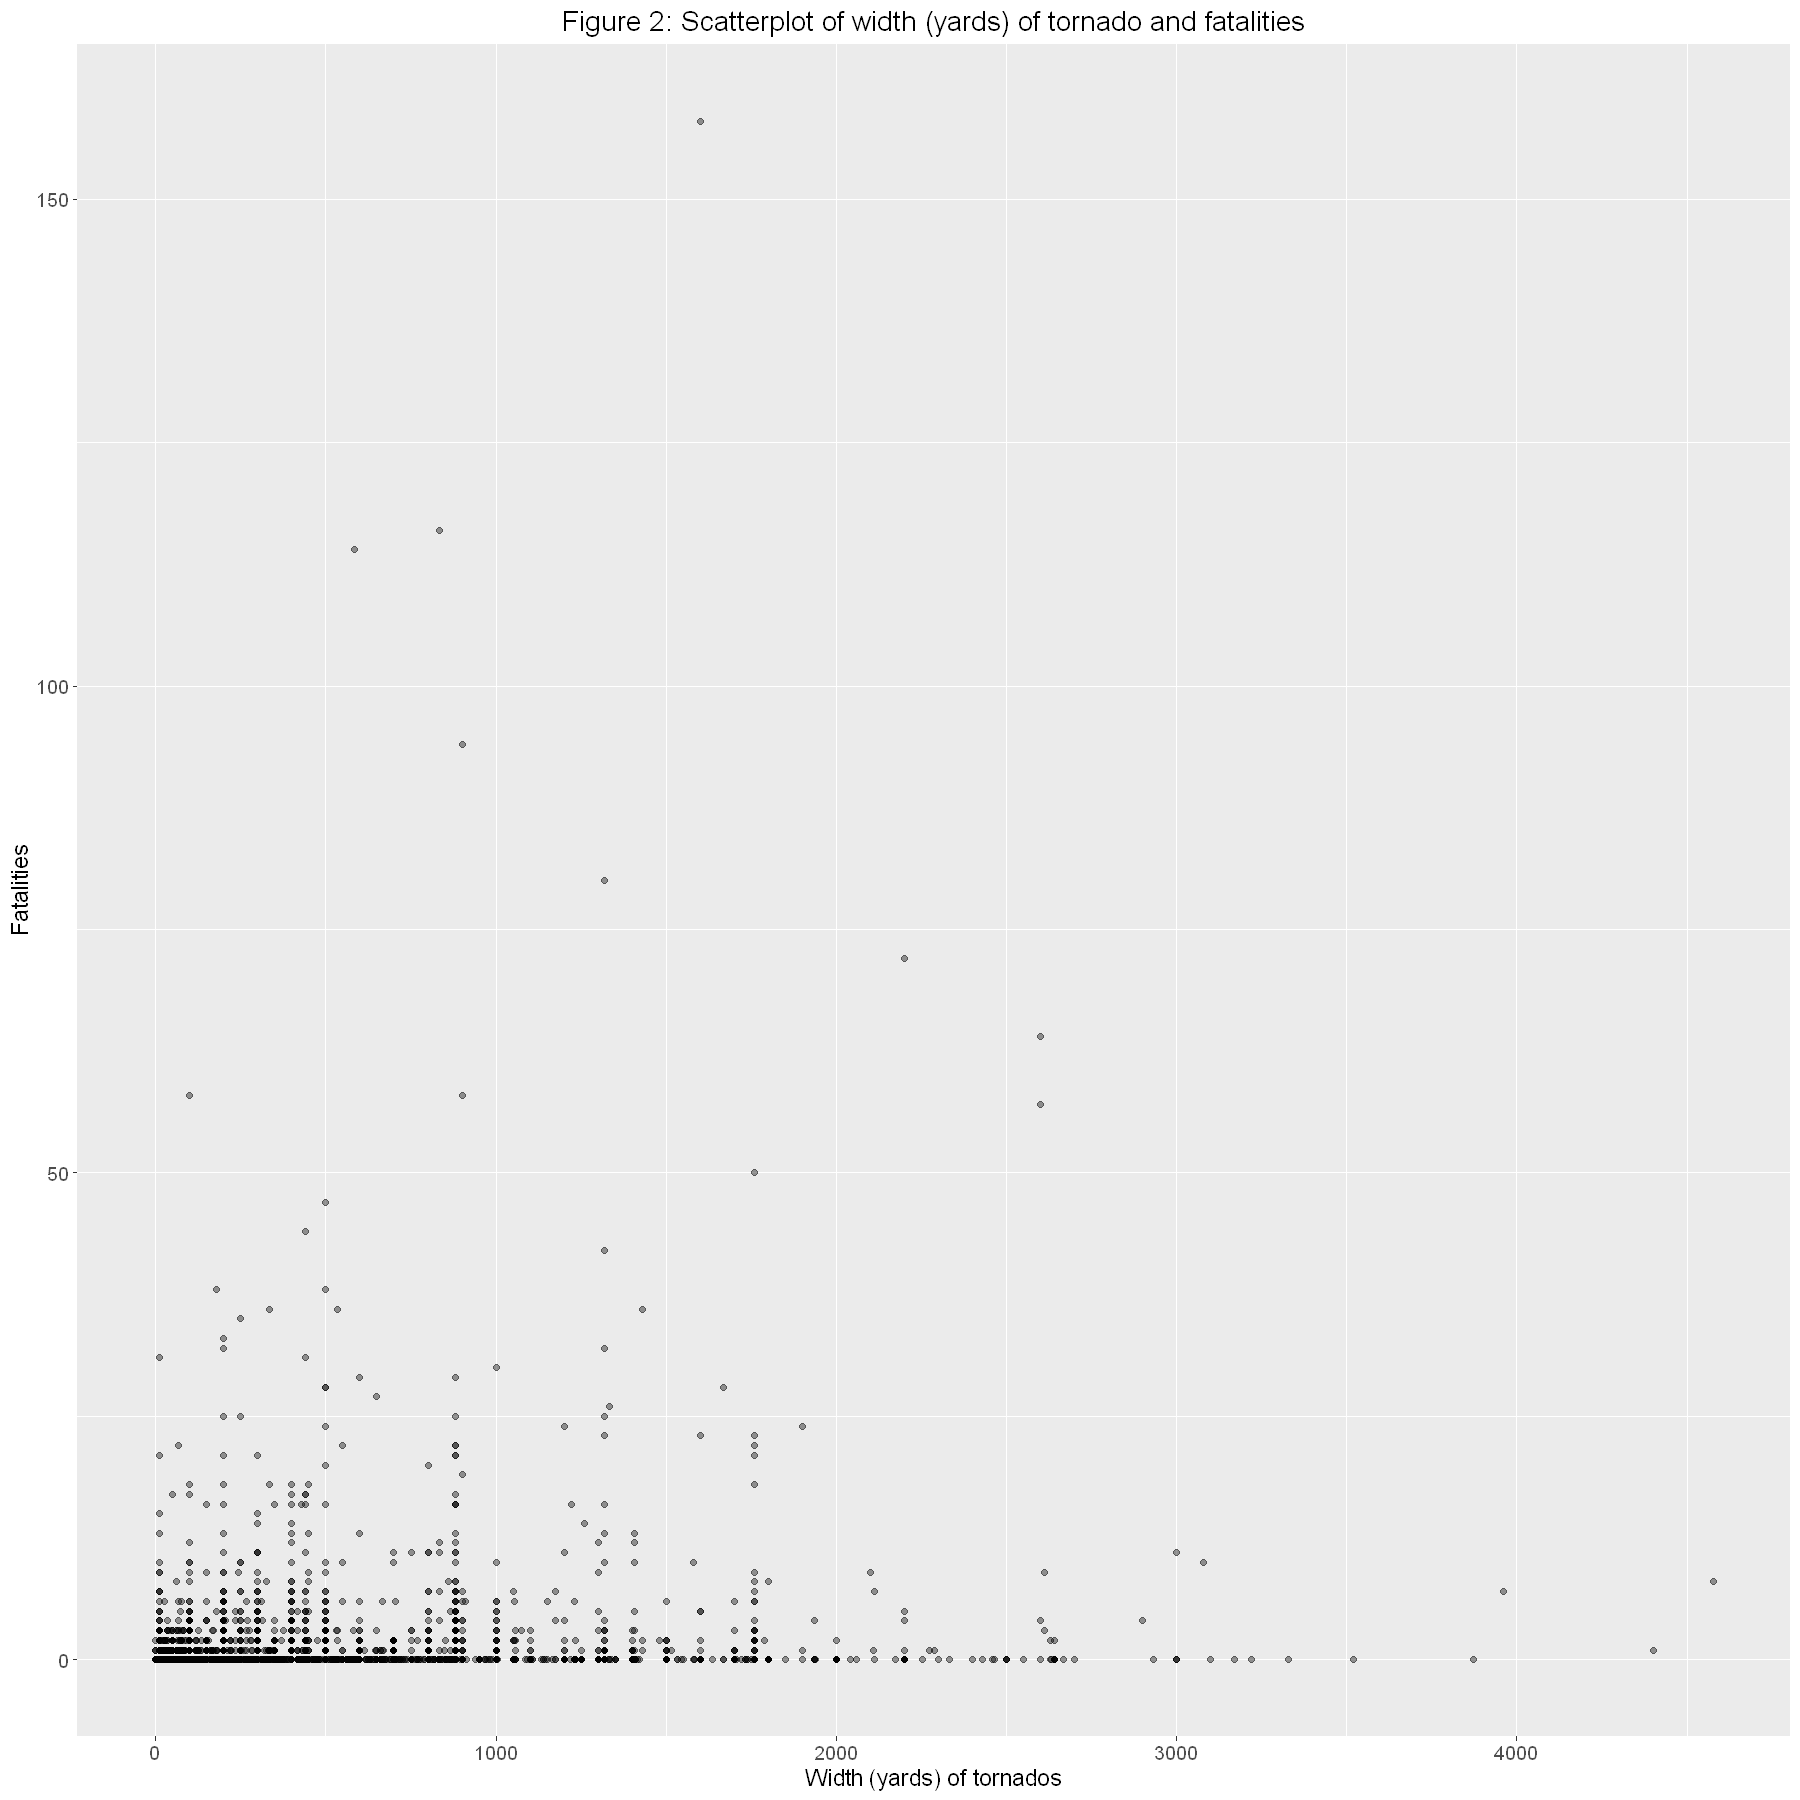

In [7]:
fatalities_width_scatterplot = ggplot(df, aes(x = width, y = fatalities)) +
    geom_point(alpha = 0.4) +
    xlab("Width (yards) of tornados") +
    ylab("Fatalities") +
    theme(text = element_text(size = 14), plot.title = element_text(hjust = 0.5)) + 
    ggtitle("Figure 2: Scatterplot of width (yards) of tornado and fatalities")
fatalities_width_scatterplot

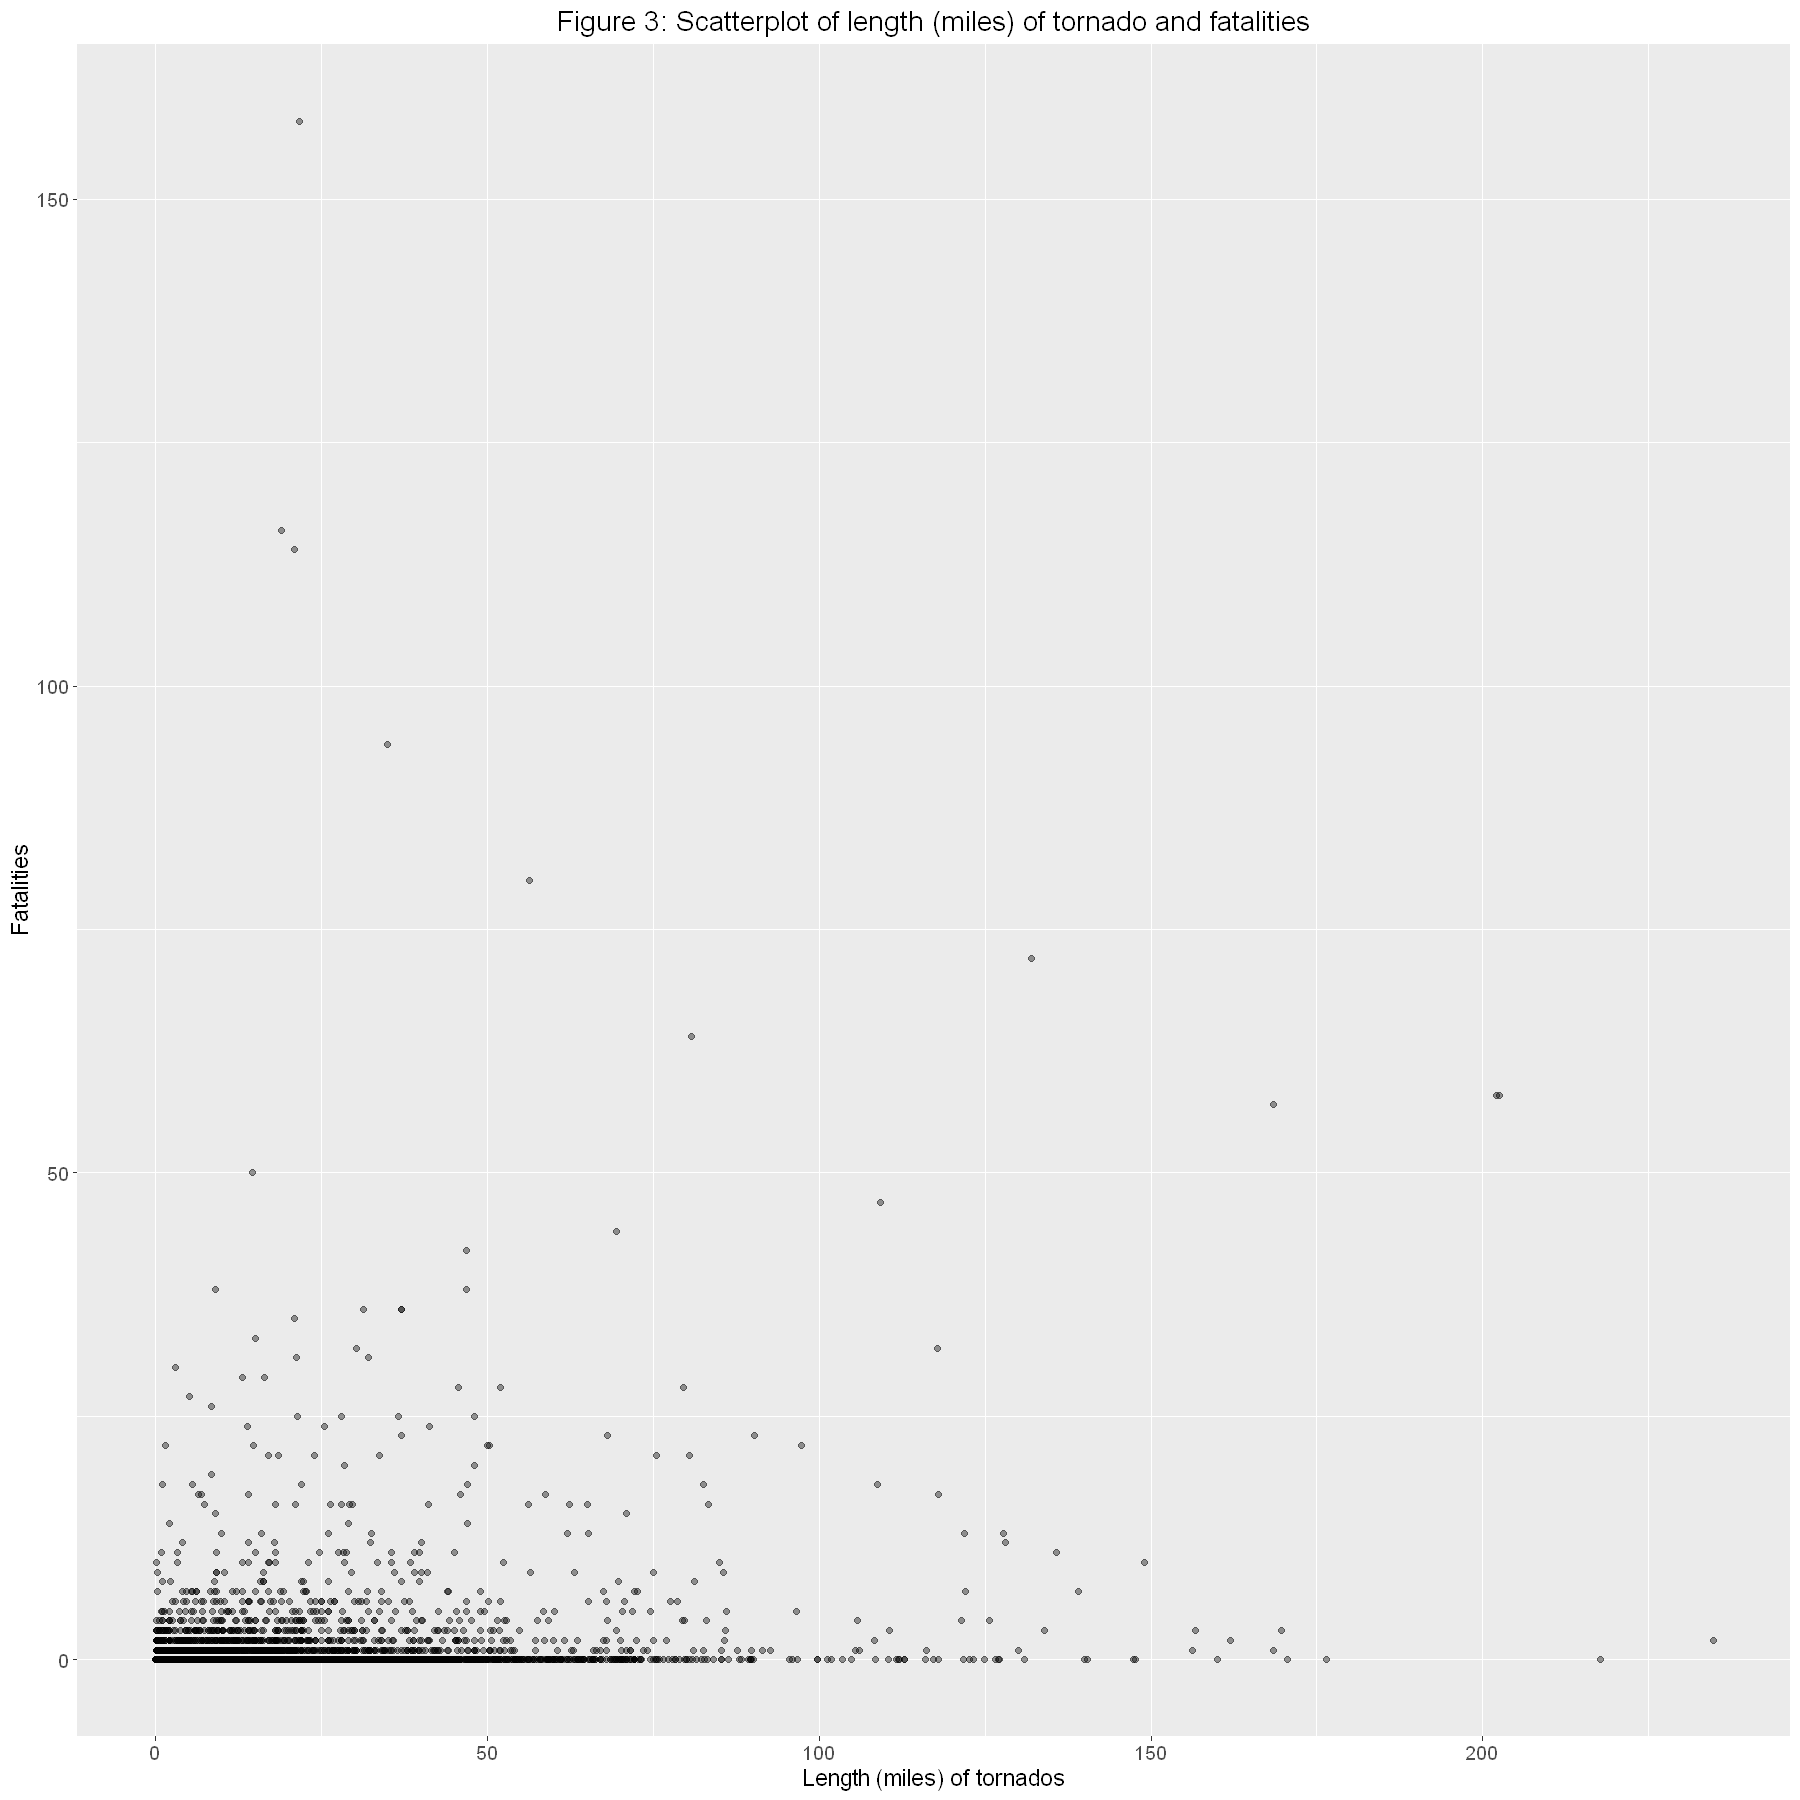

In [8]:
fatalities_length_scatterplot = ggplot(df, aes(x = length, y = fatalities)) +
    geom_point(alpha = 0.4) +
    xlab("Length (miles) of tornados") +
    ylab("Fatalities") +
    theme(text = element_text(size = 14), plot.title = element_text(hjust = 0.5)) + 
    ggtitle("Figure 3: Scatterplot of length (miles) of tornado and fatalities")
fatalities_length_scatterplot

Based on the correlation matrix, we decide to use `length` and `width` as features in our model as they are numerical unlike `mag`. 

## Model selection and analysis

7. We split our data into two sets: `train_df` and `test_df`. `train_df` consists of 75% of our original data set and is used to train our regression model. The remaining 25% of our original data is `test_df`, which we use later to test the accuracy of our model at prediction. 

In [10]:
set.seed(2000)

data_split <- initial_split(df, prop = 0.75, strata = fatalities)
train_df <- training(data_split)
test_df <- testing(data_split)

8. As mentioned previously, our group has decided that we will use a linear regression model to predict tornado casualties. We will be using the variables `width` and `length` as our predictors. The former is a measure of the width of a tornado, while the latter is a measure of length. The units of measurements are yards and miles, respectively.

   Now that we have our training data `train_df`, we can fit our linear regression model. We will first specify our model, and then proceed to fit our model and obtain the regression coefficients.

In [11]:
# specify prediction model
lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

# specify recipe
lm_recipe <- recipe(fatalities ~ length + width, data = df)

# fit the model based on the recipe, specification and training data
lm_fit <- workflow() |>
  add_recipe(lm_recipe) |>
  add_model(lm_spec) |>
  fit(data = train_df)

lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)       length        width  
 -0.1183680    0.0367960    0.0007337  


9. Now that we have our model, we can predict on the testing data `test_df` to assess how well it does.

In [12]:
# Use lm_fit to predict on test_df and output RMSPE to assess model's test error
lm_test_results <- lm_fit |>
  predict(test_df) |>
  bind_cols(test_df) |>
  metrics(truth = fatalities, estimate = .pred)

lm_test_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.00567700
rsq,standard,0.08983574
mae,standard,0.22985357


**Table 2**: Results from model with outliers

10. We can visualize our linear regression model to get a better idea of how well it performs.

Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Transformation introduced infinite values in continuous y-axis"


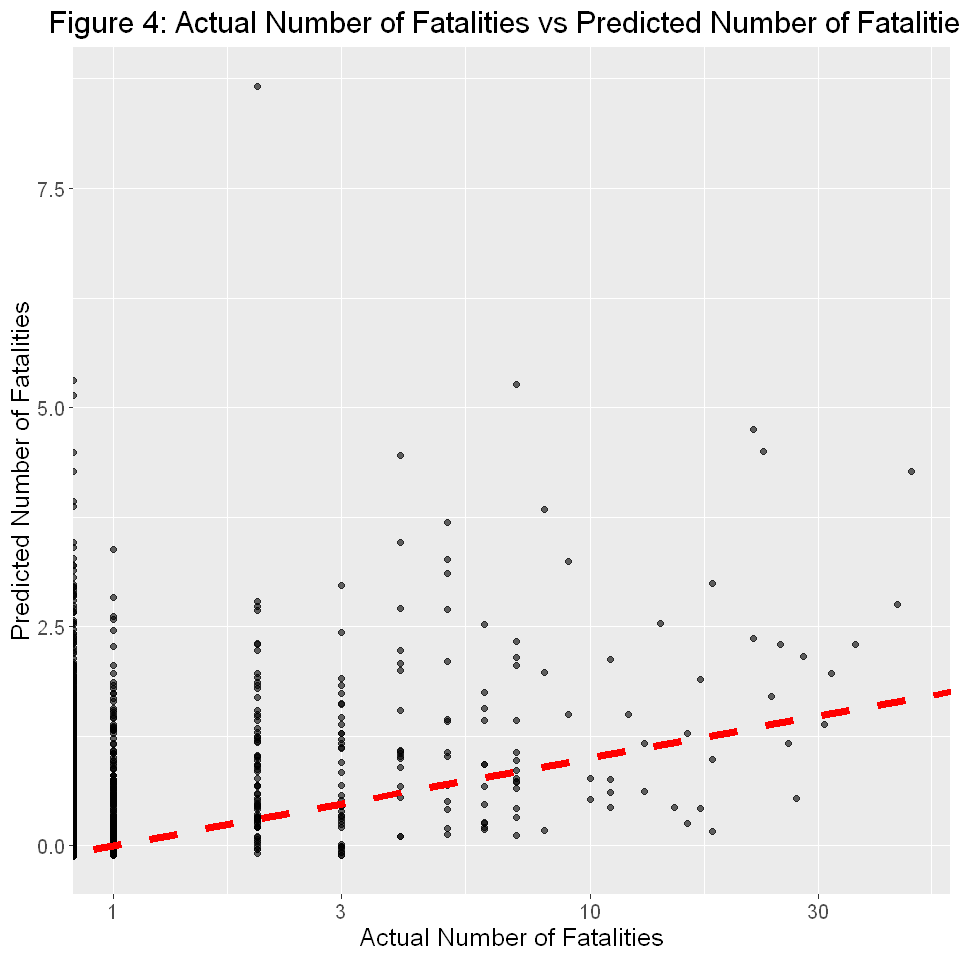

Warning message:
"Transformation introduced infinite values in continuous y-axis"


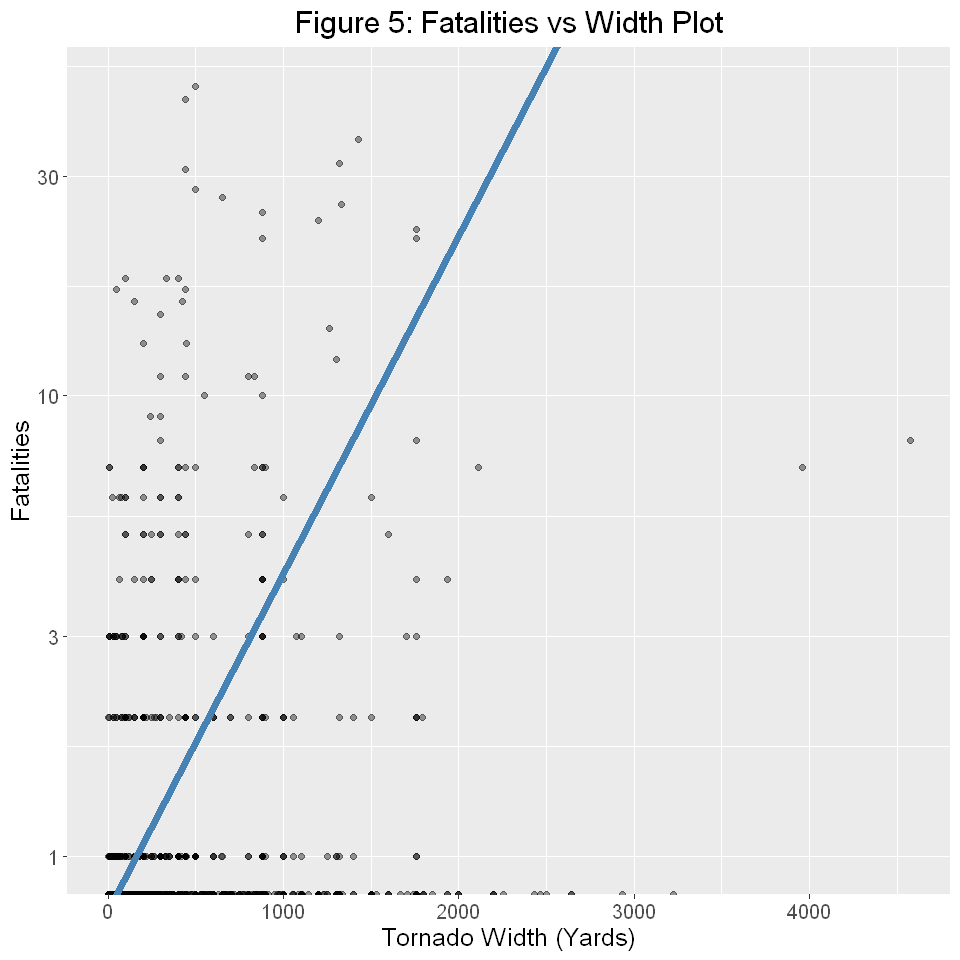

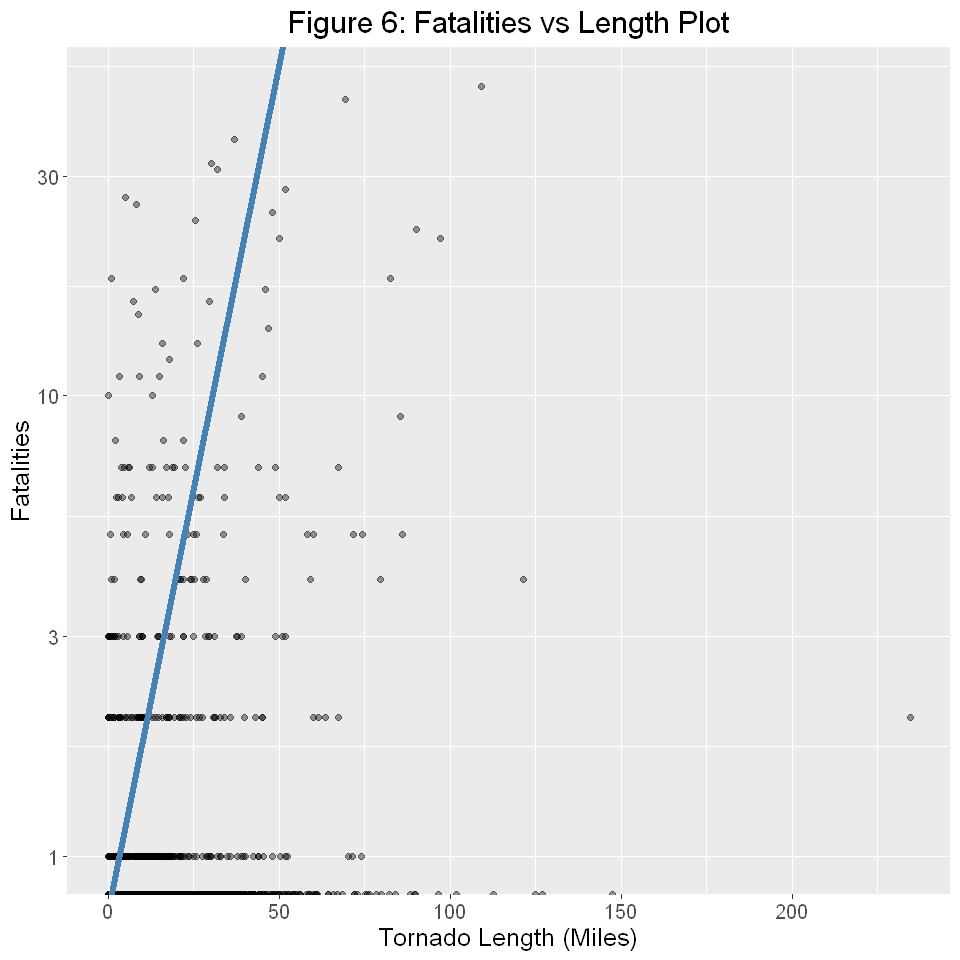

In [14]:
# Creating plots showing accuracy of linear regression model
fatal_rsmpe <- lm_test_results |>
    filter(.metric == "rmse") |>
    select(.estimate) |>
    pull()

fatal_predictions <- lm_fit |>
    predict(test_df) |>
    bind_cols(test_df)

options(repr.plot.width = 8, repr.plot.height = 8)

## Note: Red line represents where points would be plotted if the model was 100% accurate
fatal_model_viz <- ggplot(fatal_predictions, aes(x = fatalities, y = .pred)) +
    geom_point(alpha = 0.6) +
    # geom_line(data = fatal_predictions,
    #        mapping = aes(x = fatalities, y = .pred),
    #        color = "steelblue",
    #        linewidth = 1) +
    geom_abline(intercept = 0, slope = 1, color = "red", linetype = "dashed", linewidth = 2)+
    scale_x_continuous(trans = "log10") + 
    xlab("Actual Number of Fatalities") +
    ylab("Predicted Number of Fatalities") +
    ggtitle("Figure 4: Actual Number of Fatalities vs Predicted Number of Fatalities") +
    theme(text = element_text(size = 15), plot.title = element_text(hjust = 0.5))

fatal_model_viz

## Note: Blue line represents predicted values based on our regression model when tornado length = 0
fatal_widths_plot <- ggplot(test_df, aes(x = width, y = fatalities)) +
     geom_point(alpha = 0.4) +
     # geom_line(data = fatal_predictions,
     #       mapping = aes(x = width, y = .pred),
     #       color = "steelblue",
     #       linewidth = 1) +
     geom_abline(intercept = -0.1183680, slope = 0.0007337, color = "steelblue", linewidth = 2) +
     scale_y_continuous(trans = "log10") + 
     xlab("Tornado Width (Yards)") +
     ylab("Fatalities") +
     ggtitle("Figure 5: Fatalities vs Width Plot") +
     theme(text = element_text(size = 15), plot.title = element_text(hjust = 0.5))

fatal_widths_plot

## Note: Blue line represents predicted values based on our regression model when tornado width = 0
fatal_length_plot <- ggplot(test_df, aes(x = length, y = fatalities)) +
     geom_point(alpha = 0.4) +
     # geom_line(data = fatal_predictions,
     #       mapping = aes(x = length, y = .pred),
     #       color = "steelblue",
     #       linewidth = 1) +
     geom_abline(intercept = -0.1183680, slope = 0.0367960, color = "steelblue", linewidth = 2) +
     scale_y_continuous(trans = "log10") + 
     xlab("Tornado Length (Miles)") +
     ylab("Fatalities") +
     ggtitle("Figure 6: Fatalities vs Length Plot") +
     theme(text = element_text(size = 15), plot.title = element_text(hjust = 0.5))

fatal_length_plot

Note there are clear outliers in the data, thus we will perform the same analysis after removing the outliers.

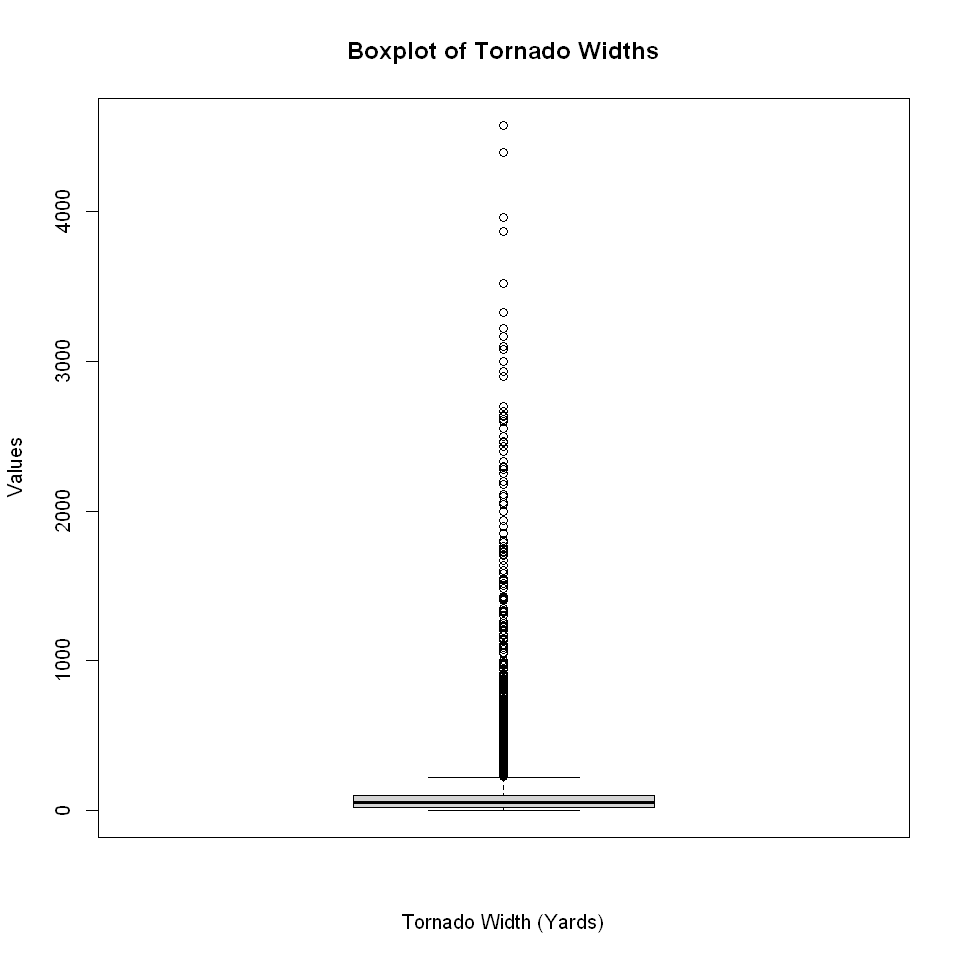

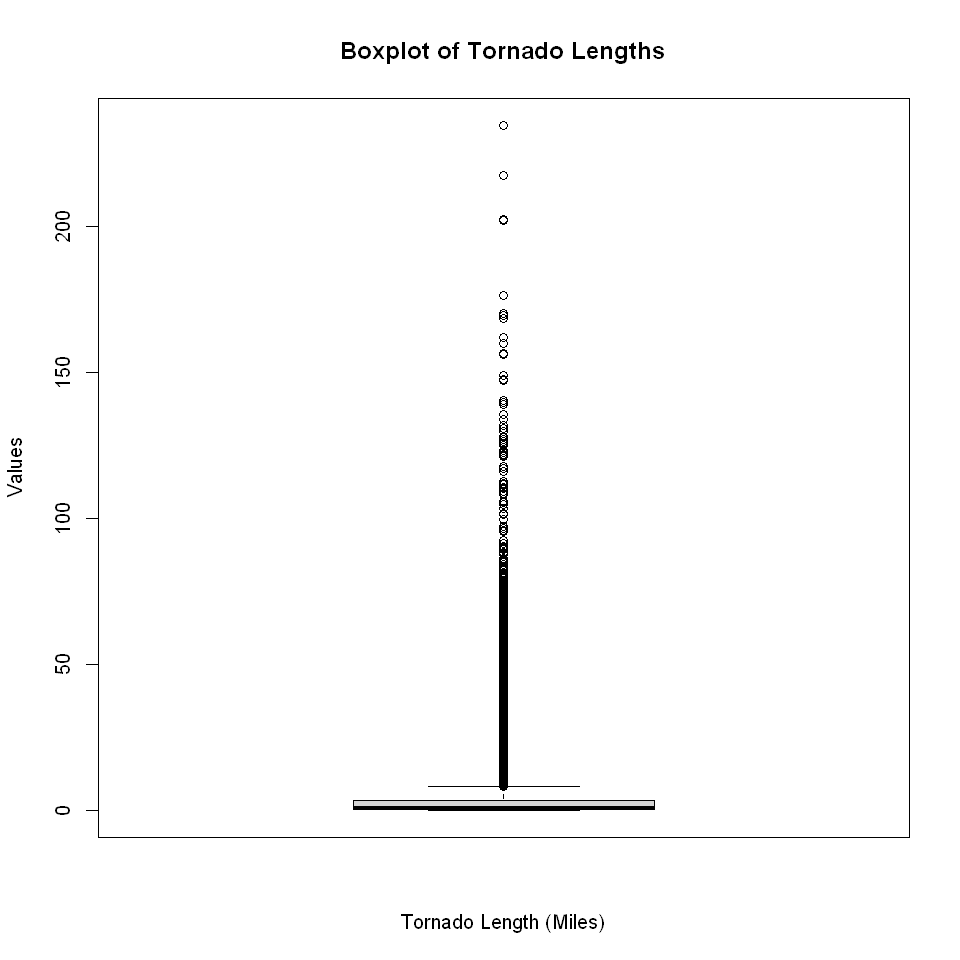

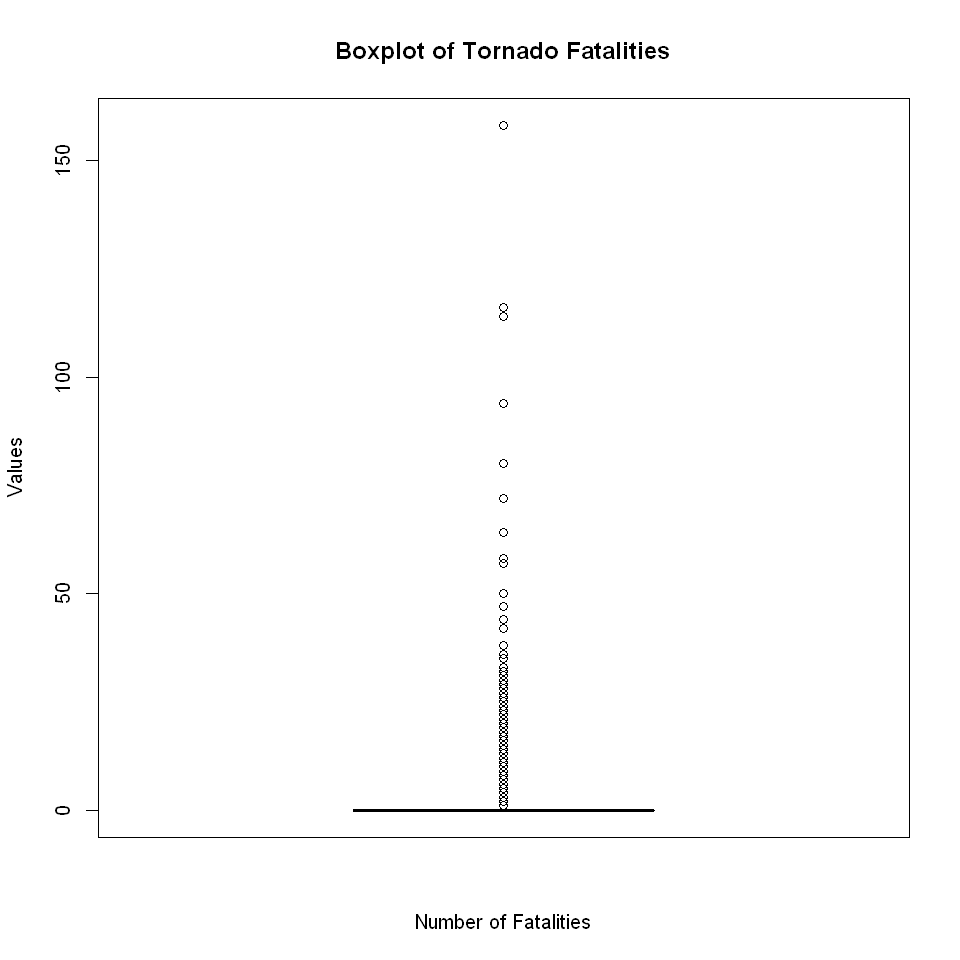

In [15]:
# Checking for outliers

boxplot(df$width, main = "Boxplot of Tornado Widths", ylab = "Values", xlab = "Tornado Width (Yards)")
boxplot(df$length, main = "Boxplot of Tornado Lengths", ylab = "Values", xlab = "Tornado Length (Miles)")
boxplot(df$fatalities, main = "Boxplot of Tornado Fatalities", ylab = "Values", xlab = "Number of Fatalities")

Note that, as the majority of tornadoes cause no fatalities and thus removing these outliers will leave us with data only containing tornadoes that caused no death, we will not be filtering outliers for fatalities.

In [16]:
# Removing outliers from data frame
width_upper_fence <- unname(quantile(df$width, 0.75)) + (1.5 * IQR(df$width))
width_lower_fence <- unname(quantile(df$width, 0.25)) - (1.5 * IQR(df$width))

length_upper_fence <- unname(quantile(df$length, 0.75)) + (1.5 * IQR(df$length))
length_lower_fence <- unname(quantile(df$length, 0.25)) - (1.5 * IQR(df$length))

outlierless_df <- df |>
    filter(width <= width_upper_fence) |>
    filter(width >= width_lower_fence) |>
    filter(length <= length_upper_fence) |>
    filter(length >= length_lower_fence)

In [14]:
# ## Creating box plots to confirm outliers have been removed
# boxplot(outlierless_df$width, main = "Boxplot of Tornado Widths", ylab = "Values", xlab = "Tornado Width (Yards)")
# boxplot(outlierless_df$length, main = "Boxplot of Tornado Lengths", ylab = "Values", xlab = "Tornado Length (Miles)")

In [17]:
# Creating new model with the new data frame without outliers

set.seed(2000)

new_data_split <- initial_split(outlierless_df, prop = 0.75, strata = fatalities)
new_train_df <- training(new_data_split)
new_test_df <- testing(new_data_split)

new_lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

# specify recipe
new_lm_recipe <- recipe(fatalities ~ length + width, data = outlierless_df)

# fit the model based on the recipe, specification and training data
new_lm_fit <- workflow() |>
  add_recipe(new_lm_recipe) |>
  add_model(new_lm_spec) |>
  fit(data = new_train_df)

new_lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)       length        width  
 -0.0022491    0.0048939    0.0001736  


In [18]:
# Use new_lm_fit to predict on new_test_df and output RMSPE to assess model's test error
new_lm_test_results <- new_lm_fit |>
  predict(new_test_df) |>
  bind_cols(new_test_df) |>
  metrics(truth = fatalities, estimate = .pred)

new_lm_test_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.189469674
rsq,standard,0.004646338
mae,standard,0.024224239


**Table 3**: Results from model without outliers

Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Transformation introduced infinite values in continuous y-axis"


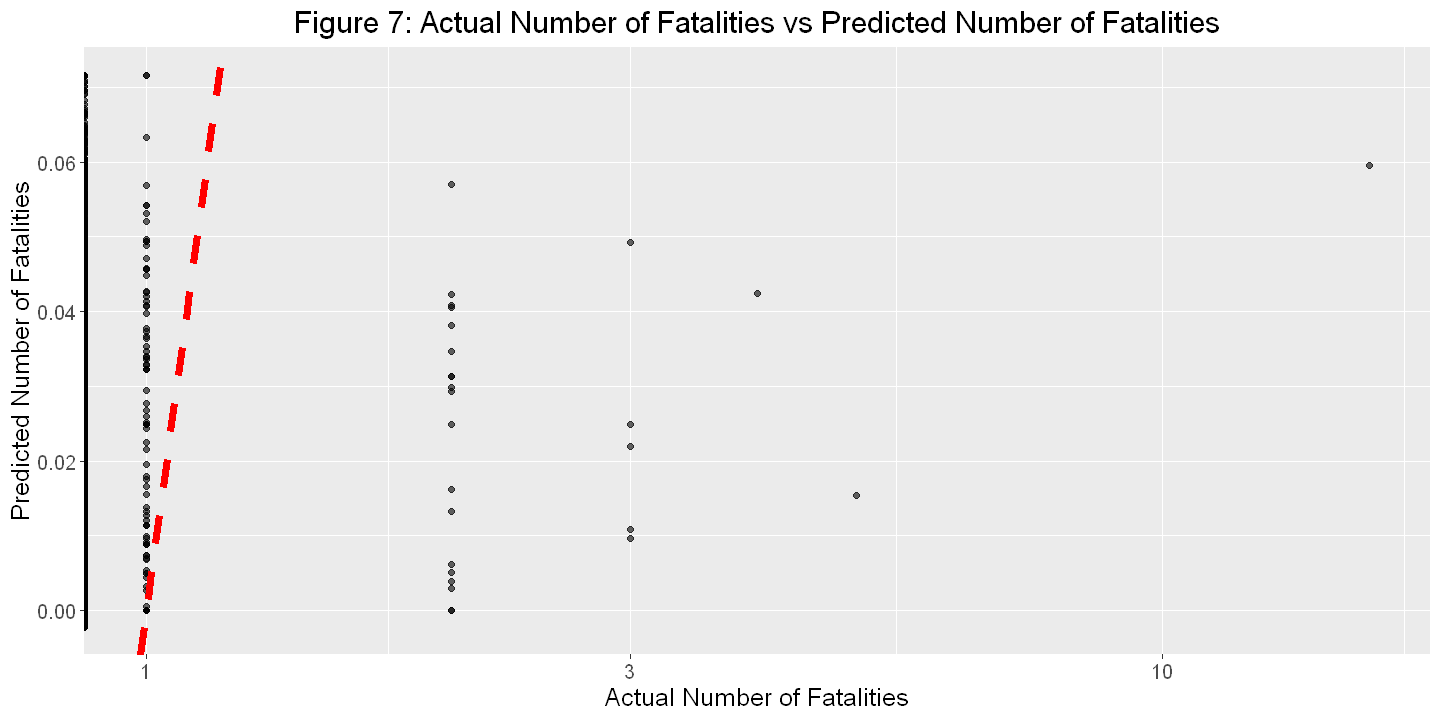

Warning message:
"Transformation introduced infinite values in continuous y-axis"


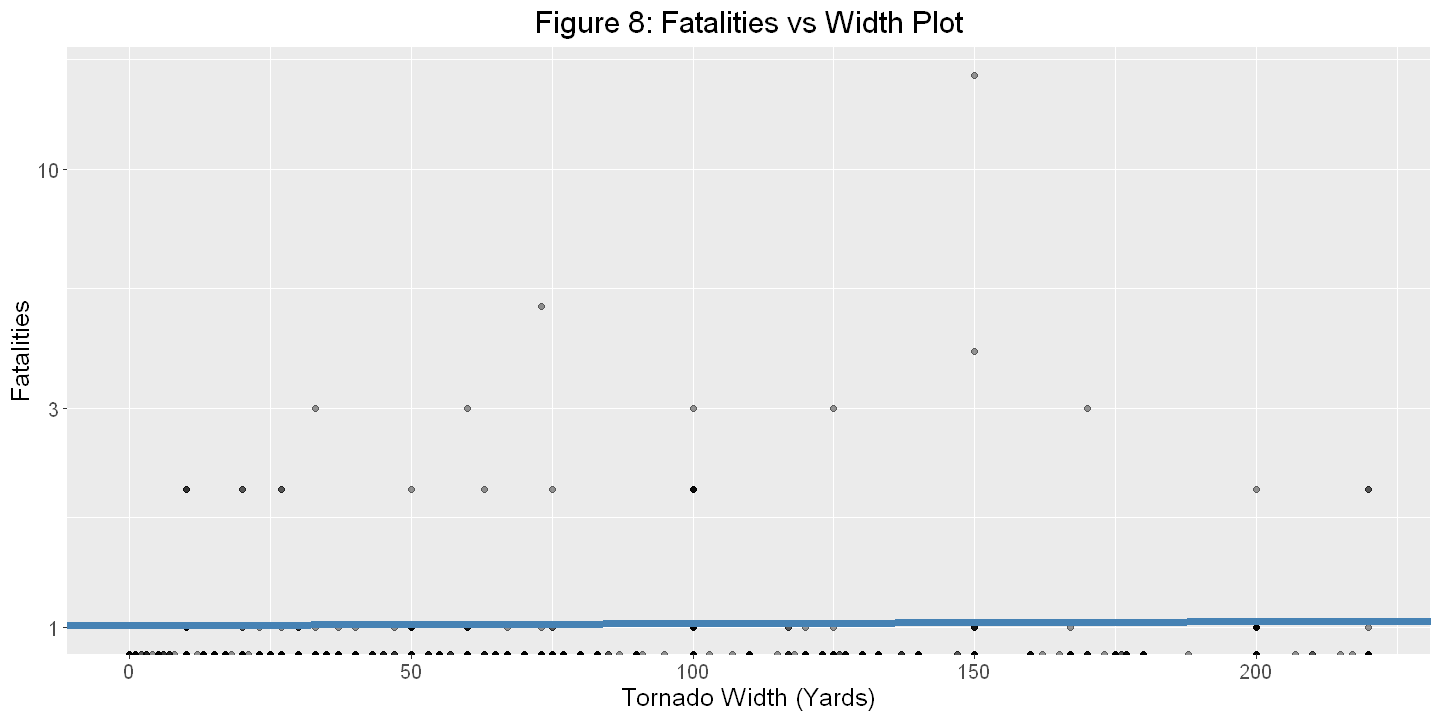

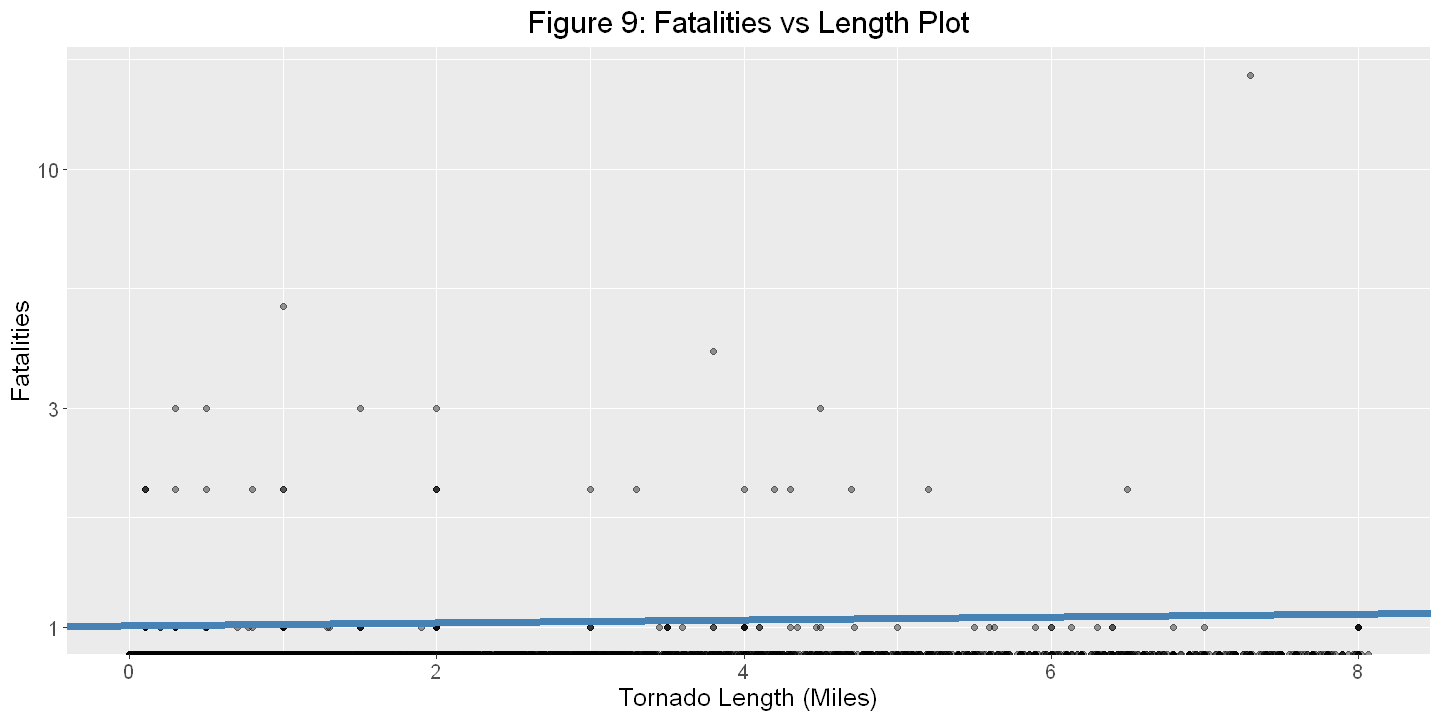

In [19]:
# Creating plots showing accuracy of new linear regression model
new_fatal_rsmpe <- new_lm_test_results |>
    filter(.metric == "rmse") |>
    select(.estimate) |>
    pull()

new_fatal_predictions <- new_lm_fit |>
    predict(new_test_df) |>
    bind_cols(new_test_df)

options(repr.plot.width = 12, repr.plot.height = 6)

## Note: Red line represents where points would be plotted if the model was 100% accurate
new_fatal_model_viz <- ggplot(new_fatal_predictions, aes(x = fatalities, y = .pred)) +
    geom_point(alpha = 0.6) +
    # geom_line(data = fatal_predictions,
    #        mapping = aes(x = fatalities, y = .pred),
    #        color = "steelblue",
    #        linewidth = 1) +
    geom_abline(intercept = 0, slope = 1, color = "red", linetype = "dashed", linewidth = 2)+
    scale_x_continuous(trans = "log10") + 
    xlab("Actual Number of Fatalities") +
    ylab("Predicted Number of Fatalities") +
    ggtitle("Figure 7: Actual Number of Fatalities vs Predicted Number of Fatalities") +
    theme(text = element_text(size = 15), plot.title = element_text(hjust = 0.5))

new_fatal_model_viz

## Note: Blue line represents predicted values based on our regression model when tornado length = 0
new_fatal_widths_plot <- ggplot(new_test_df, aes(x = width, y = fatalities)) +
     geom_point(alpha = 0.4) +
     # geom_line(data = fatal_predictions,
     #       mapping = aes(x = width, y = .pred),
     #       color = "steelblue",
     #       linewidth = 1) +
     geom_abline(intercept = 0.003074, slope = 0.00004429, color = "steelblue", linewidth = 2) +
     scale_y_continuous(trans = "log10") + 
     xlab("Tornado Width (Yards)") +
     ylab("Fatalities") +
     ggtitle("Figure 8: Fatalities vs Width Plot") +
     theme(text = element_text(size = 15), plot.title = element_text(hjust = 0.5))

new_fatal_widths_plot

## Note: Blue line represents predicted values based on our regression model when tornado width = 0
new_fatal_length_plot <- ggplot(new_test_df, aes(x = length, y = fatalities)) +
     geom_point(alpha = 0.4) +
     # geom_line(data = fatal_predictions,
     #       mapping = aes(x = length, y = .pred),
     #       color = "steelblue",
     #       linewidth = 1) +
     geom_abline(intercept = 0.003074, slope = 0.003195, color = "steelblue", linewidth = 2) +
     scale_y_continuous(trans = "log10") + 
     xlab("Tornado Length (Miles)") +
     ylab("Fatalities") +
     ggtitle("Figure 9: Fatalities vs Length Plot") +
     theme(text = element_text(size = 15), plot.title = element_text(hjust = 0.5))

new_fatal_length_plot

# Discussion and Results

Our initial exploration of features width and length demonstrated a positive correlation with our target, fatalities. Length and fatalities show a correlation of `0.237`, whereas width and fatalities show a correlation of `0.174`. The values are small but illustrate a stronger positive relationship between length and fatalities.

Before constructing our model, we performed a 75/25 split on our data for reproducibility and validity.

From our multivariable linear regression model with the inclusion of outliers, we can write an equation of best fit: 

$Tornado$ $fatalities$ = $0.0367960$ x ($length$ $of$ $tornado$) + $0.0007337$ x ($width$ $of$ $tornado$) - $0.1183680$

The coefficients and intercept of the equation are positive but small demonstrating that our features `length` and `width` may not have a large impact on predicting tornado fatalities. This signifies that the features may not be leading to precise predictions. Our results follow our initial exploration of the data, where we saw small positive correlations.

On the other hand, we obtain an RMSPE score for this multivariable linear regression of `1.00567700` tornado fatalities (Table 2). This prediction error is very low, indicating that our model fits the data well and our predictions are more precise. 

As noted in our analysis section, removing the outliers leaves us with tornadoes that cause no deaths. Nonetheless, we decided to keep the linear regression model without the outliers to observe if any differences were seen in the equation and RMSPE score. 

The equation of best fit for our multilinear regression model without the outliers is: 

$Tornado$ $fatalities$ = $0.0048939$ x ($length$ $of$ $tornado$) + $0.0001736$ x ($width$ $of$ $tornado$) - $0.0022491$

Compared to the model including outliers, the coefficients and the intercept are much smaller, implying that these features have less of an impact on predicting tornado fatalities and are more likely to lead to less precise predictions. 

The RMSPE score here is `0.189469674` tornado fatalities (Table 3), suggesting that it makes fewer errors than the model with the outliers.

From Figure 5, 6, 8, and 9, the plots from the model with the outliers seem more interpretable than the ones from the model without the outliers, as the slope is an almost flat one. On the other hand, by observing Figure 4 and 7, the plots showing the actual number of fatalities vs the predicted number of fatalities of both models, we can conclude that the reason why the model without the outliers has a lower RMSPE score is because the outliers were removed, thus making it easier to predict the fatalities that are more closely located than fatalities that are along a longer range. 

Therefore, we can conclude that our model has a lower RMSPE score, which is preferable in a multilinear regression model. However, it also does not have very strong coefficients for predicting the number of fatalities. 

In terms of expectations, given the small correlations that length and width have with the number of tornado fatalities, it is expected that our model does not have very large coefficients. In terms of the RMSPE score, we did not have an expectation as to how our model would perform. However, we did not expect the RMSPE score to be so low as typically if the coefficients are smaller, then they have less impact on the predictions and thus may lead to more erroneous predictions. 

Despite the low coefficients of our model equations, the low RMSPE scores suggest that if this model were to be deployed to predict the number of fatalities from tornadoes in the U.S., then it may have the ability to predict them without so much error. Therefore, our model could have some utility in such aspects. 

However, we believe that because of the limitations of our model, it would be interesting to observe the impact of using other features to predict the number of fatalities from tornadoes, such as `mag`. Furthermore, it could also be valuable to explore how well we could predict the number of injuries using the same features that we did, namely `length` and `width`. The total number of casualties (fatalities and injuries) could also be predicted using `length` and `width` and perhaps other features. 

# References

Angerer, P., Kluyver, T., Schulz, J., abielr, Sa, D. F. de, Hester, J., karldw, Foster, D., & Sievert, C. (2023, January 26). *repr (1.1.6): Serializable Representations.* https://cran.r-project.org/package=repr

Chinchar, A. (2022, November 28). *Here’s Why the US has More Tornadoes than Any Other Country*. CNN. https://www.cnn.com/2022/11/28/weather/us-leads-tornado-numbers-tornado-alley-xpn/index.html

Hadley Wickham, & RStudio. (2017). *tidyverse (2.0.0): Easily Install and Load the “Tidyverse.”* https://cran.r-project.org/package=tidyverse

Kuhn , M., Wickham, H., Software, P., & PBC. (2023, August 24). *tidymodels (1.1.0): Easily Install and Load the “Tidymodels” Packages*. https://cran.r-project.org/package=tidymodels

R Core Team. (2022). *R (4.3.2): A Language and Environment for Statistical Computing*. R Foundation for Statistical Computing. https://www.r-project.org/

Revelle, W. (2019). *psych (2.3.3): Procedures for Psychological, Psychometric, and Personality Research*. https://cran.r-project.org/package=psych

Schloerke, B., Cook, D., Larmarange, J., Briatte, F., Marbach, M., Thoen, E., Elberg, A., Toomet, O., Crowley, J., Hofmann, H., & Wickham, H. (2020, June 6). *GGally (2.1.2): Extension to “ggplot2.”* https://cran.r-project.org/package=GGally

Storm Prediction Center. (2023, February 19). *F5 and EF5 tornadoes of the United States - 1950-present (SPC)*. Noaa.gov; NOAA’s National Weather Service. https://www.spc.noaa.gov/faq/tornado/f5torns.html 

*tidytuesday/data/2023/2023-05-16 at master · rfordatascience/tidytuesday*. GitHub. https://github.com/rfordatascience/tidytuesday/tree/master/data/2023/2023-05-16